# 寿县飞艇观测数据：2024臭氧个例分析

## WRF模拟MDA8臭氧垂直分布
---
Evan \
2024-10-31

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import configparser
config = configparser.ConfigParser()
config.read('../src/config.ini')

import sys
sys.path.append('../src')
from findpoint import nearest_position

import warnings
warnings.filterwarnings("ignore")

In [2]:
datapath = config.get('chem', 'saprc')

# 读取指定时间范围内的数据
year  = 2024
month = 4
days  = np.arange(7,15)
hours = list(range(1, 24)) + [0] # 使hour按照1-23,0的顺序排列
filelist = []
for day in days:
    date = f'{year}{month:02d}{day:02d}'
    for hour in hours:
        if hour != 0:
            filelist.append(datapath + date + '/' + f'wrfout_d01_{year}-{month:02d}-{day:02d}_{hour:02d}:00:00')
        else:
            # 第n天路径下包含n+1天0时刻的数据，即第n天的0时刻数据位于n-1天的路径下
            filelist.append(datapath + date + '/' + f'wrfout_d01_{year}-{month:02d}-{day+1:02d}_00:00:00')

# 批量读取数据
ds = xr.open_mfdataset(filelist, combine='nested', concat_dim='Time')

# 构造本地时间索引
start_time = pd.to_datetime('2024-04-07 01:00:00') + pd.Timedelta(hours=8) # UTC+8
timestamps = [start_time + pd.Timedelta(hours=i) for i in range(len(filelist))]
time_index = pd.DatetimeIndex(timestamps)
# 将时间索引写入时间维
ds = ds.assign_coords(Time=('Time', time_index))

o3 = ds['o3']*1000 # 单位转换为ppb

# 将o3按照时间维度计算MDA8
# mda8 = o3.rolling(Time=8).mean(dim='Time').resample(Time='D').max(dim='Time')

In [3]:
# 飞艇位置
std_lon = 116.72
std_lat = 32.59

# 格点位置
lon = ds['XLONG'][0,:,:]
lat = ds['XLAT'][0,:,:]

# 寻找最近格点
nr_point = nearest_position(std_lon, std_lat, lon.values, lat.values)

# 提取该格点的o3数据
nr_o3 = o3.isel(south_north=nr_point[0], west_east=nr_point[1])

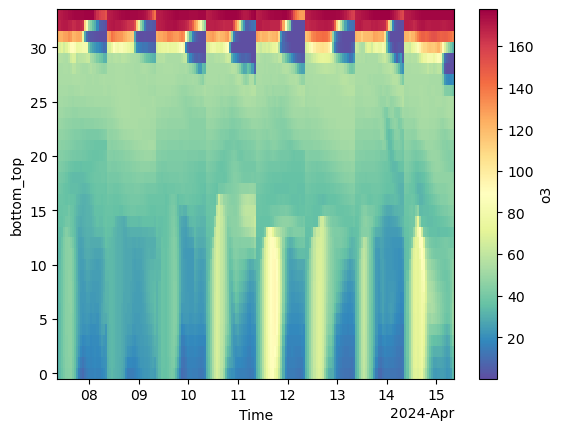

In [4]:
nr_o3.plot(x='Time',y='bottom_top',cmap='Spectral_r')

In [5]:
# 计算海拔高度
phb = ds['PHB']
ph = ds['PH']

height = (phb + ph)/9.81
nr_height = height.isel(south_north=nr_point[0], west_east=nr_point[1])

In [6]:
nr_height[0,:22].values

array([  21.829432,   62.575188,  103.4272  ,  144.41289 ,  185.53885 ,
        268.2226  ,  351.4996  ,  435.38614 ,  519.9157  ,  605.10815 ,
        691.01404 ,  777.65424 ,  865.05084 , 1041.9552  , 1221.9149  ,
       1405.329   , 1592.5007  , 1783.7295  , 2078.617   , 2383.73    ,
       2806.5564  , 3361.4463  ], dtype=float32)

In [7]:
use_o3 = nr_o3.sel(bottom_top=slice(0,22))
use_h = nr_height.sel(bottom_top_stag=slice(0,22))

xlen = np.arange(0,use_o3.shape[0])
xx = np.tile(xlen, (use_o3.shape[1],1))
xx = xx.T
yy = use_h.values

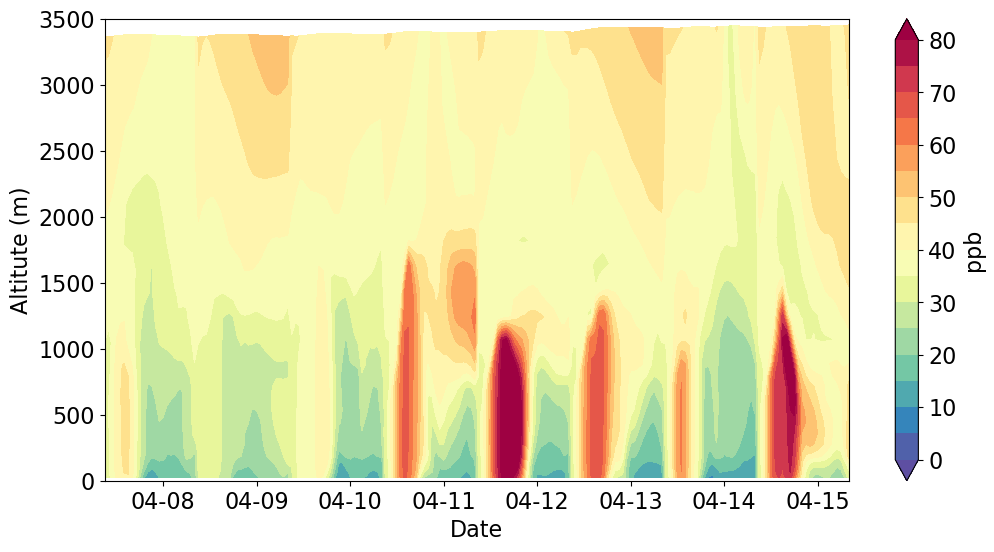

In [9]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

cf = ax.contourf(xx,yy,use_o3.values, levels=np.arange(0, 81, 5),
                 extend='both', cmap='Spectral_r')

cbar = fig.colorbar(cf, ax=ax,)
cbar.set_ticks(np.arange(0, 81, 10))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('ppb', fontsize=16)

ax.set_xticks(np.arange(24-9, use_o3.shape[0], 24))
dates = pd.date_range(start='2024-04-08', end='2024-04-15', freq='D')
ax.set_xticklabels(dates.strftime('%m-%d'), fontsize=16)
ax.set_yticks(np.arange(0, 3600, 500))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_ylabel('Altitute (m)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)

plt.show()

## 加入观测数据

In [ ]:
obspath = config.get('base', 'DataPath')
obs = pd.read_excel(obspath + 'CaseOzone.xlsx',index_col=0)

In [32]:
# 将obs按照index小时重采样
obs_hourly = obs.resample('H').mean()
# 对缺失值进行插值
obs_hourly = obs_hourly.interpolate(method='linear')

# 提取飞艇高度
height_met = obs_hourly['Height_Meteor_airship_height']
# 提取o3浓度,单位转换为ppb
o3_airship = obs_hourly['O3_airship']*22.4/48

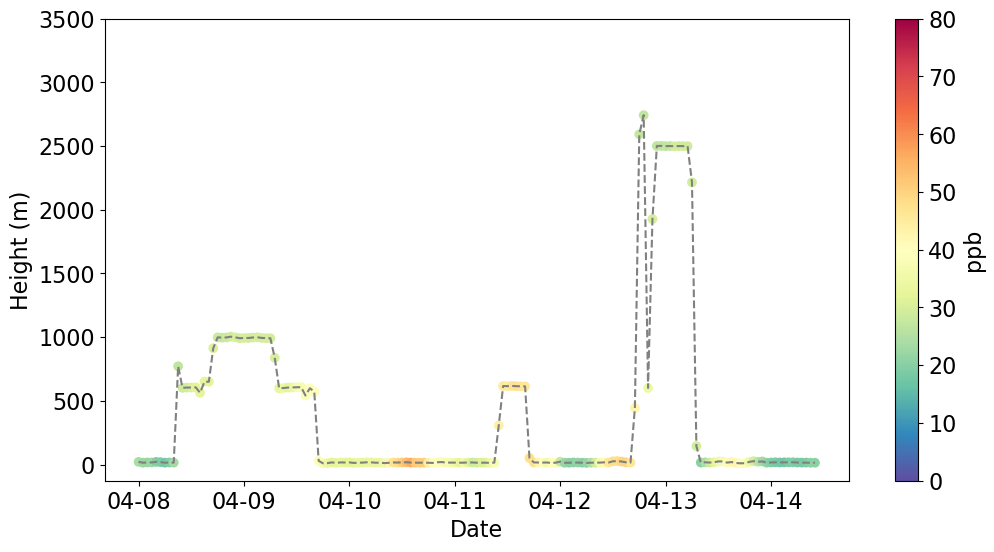

In [34]:
# 将o3_airship值按照高度绘制散点图
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
xobs = o3_airship.index.values
ax.plot(xobs, height_met, color='gray', linestyle='--')
ax.scatter(xobs, height_met, c=o3_airship, cmap='Spectral_r',vmin=0, vmax=80)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Height (m)', fontsize=16)
ax.set_xticks(xobs[::24])
ax.set_xticklabels(pd.to_datetime(xobs[::24]).strftime('%m-%d'), fontsize=16)
ax.set_yticks(np.arange(0, 3600, 500))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
cbar = fig.colorbar(ax.collections[0], ax=ax)
cbar.set_label('ppb', fontsize=16)
cbar.set_ticks(np.arange(0, 81, 10))
cbar.ax.tick_params(labelsize=16)
plt.show()


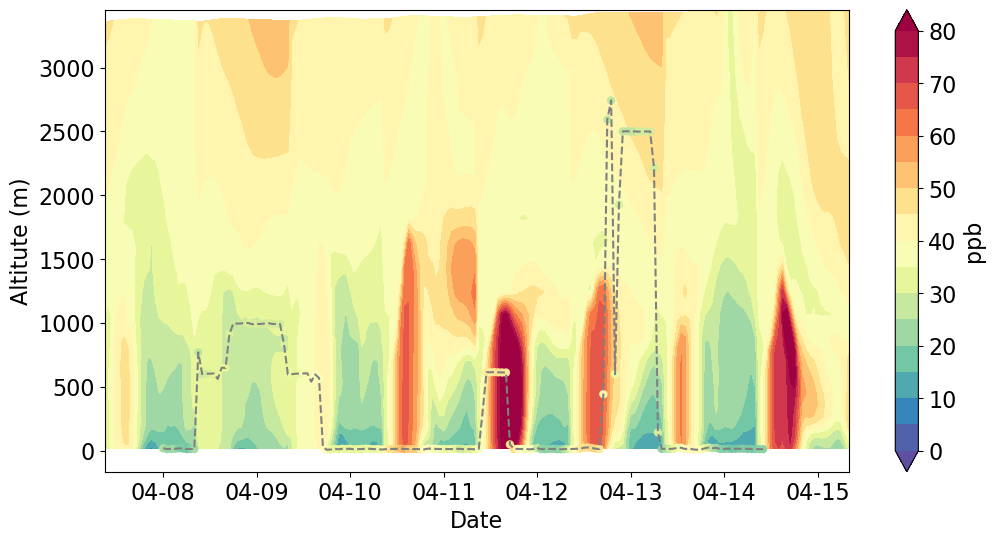

In [53]:
# 将两幅图合并
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
cf = ax.contourf(xx,yy,use_o3.values, levels=np.arange(0, 81, 5),
                 extend='both', cmap='Spectral_r')
cbar = fig.colorbar(cf, ax=ax,)
cbar.set_ticks(np.arange(0, 81, 10))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('ppb', fontsize=16)

ax.set_xticks(np.arange(24-9, use_o3.shape[0], 24))
dates = pd.date_range(start='2024-04-08', end='2024-04-15', freq='D')
ax.set_xticklabels(dates.strftime('%m-%d'), fontsize=16)
ax.set_yticks(np.arange(0, 3600, 500))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_ylabel('Altitute (m)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)

xxobs = np.arange(15, 15+len(o3_airship))
ax.plot(xxobs, height_met, color='gray', linestyle='--')
ax.scatter(xxobs, height_met, c=o3_airship, cmap='Spectral_r',
           vmin=0, vmax=80,edgecolors='none')
plt.show()

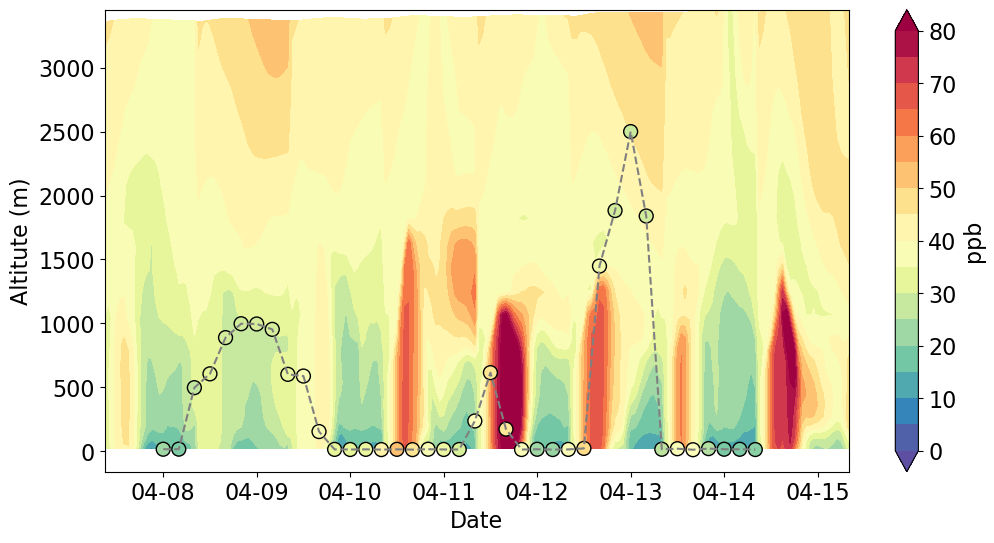

In [62]:
# 将o3_airship重采样为每4小时一个点
o3_airship_4h = o3_airship.resample('4H').mean()
height_met_4h = height_met.resample('4H').mean()

# 绘制填色和打点图
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
cf = ax.contourf(xx,yy,use_o3.values, levels=np.arange(0, 81, 5),
                 extend='both', cmap='Spectral_r')
cbar = fig.colorbar(cf, ax=ax,)
cbar.set_ticks(np.arange(0, 81, 10))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('ppb', fontsize=16)

ax.set_xticks(np.arange(24-9, use_o3.shape[0], 24))
dates = pd.date_range(start='2024-04-08', end='2024-04-15', freq='D')
ax.set_xticklabels(dates.strftime('%m-%d'), fontsize=16)
ax.set_yticks(np.arange(0, 3600, 500))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_ylabel('Altitute (m)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)

xxobs = np.arange(15, 15+len(o3_airship),4)
ax.plot(xxobs, height_met_4h, color='gray', linestyle='--')
ax.scatter(xxobs, height_met_4h, c=o3_airship_4h, cmap='Spectral_r',
           vmin=0, vmax=80,edgecolors='k', s=100)
plt.show()
